In [1]:
import cv2
img = cv2.imread("./Dataset/6.jpg", cv2.IMREAD_COLOR)

In [2]:
# Define the helper function

import numpy as np
def decode_segmap(image, nc=21):
    label_colors = np.array([(0, 0, 0),  # 0=background
    # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
    (128, 0, 0), (0, 128, 0), (255, 255, 255), (0, 0, 128), (128, 0, 128),
    # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
    (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
    # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
    (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (255, 255, 255),
    # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
    (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]
        rgb = np.stack([r, g, b], axis=2)
    return rgb

In [3]:
pip install torchvision

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torch
from PIL import Image
def segment(net, path, show_orig=True, dev='cuda'):
    img = Image.open(path)
    if show_orig: 
        plt.imshow(img); 
        plt.axis('off'); 
        plt.show()
    # Comment the Resize and CenterCrop for better inference results
    trf = T.Compose([T.ToTensor(),
    T.Normalize(mean = [0.485, 0.456, 0.406],
    std = [0.229, 0.224, 0.225])])
    inp = trf(img).unsqueeze(0).to(dev)
    out = net.to(dev)(inp)['out']
    om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
    rgb = decode_segmap(om)
    return rgb

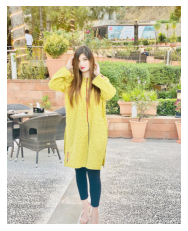

RuntimeError: CUDA out of memory. Tried to allocate 24.00 MiB (GPU 0; 7.79 GiB total capacity; 6.03 GiB already allocated; 39.12 MiB free; 6.17 GiB reserved in total by PyTorch)

In [5]:
from torchvision import models
dlab = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()
rgb=segment(dlab, "./Dataset/6.jpg")
## If there are multiple labeled objects in the image, use the below code to have only the target as the foreground
rgb[rgb!=255]=0

In [3]:
pip install Image

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [15]:
from PIL import Image
import numpy as np

def rgb_to_hsv(rgb):
    # Translated from source of colorsys.rgb_to_hsv
    # r,g,b should be a numpy arrays with values between 0 and 255
    # rgb_to_hsv returns an array of floats between 0.0 and 1.0.
    rgb = rgb.astype('float')
    hsv = np.zeros_like(rgb)
    # in case an RGBA array was passed, just copy the A channel
    hsv[..., 3:] = rgb[..., 3:]
    r, g, b = rgb[..., 0], rgb[..., 1], rgb[..., 2]
    maxc = np.max(rgb[..., :3], axis=-1)
    minc = np.min(rgb[..., :3], axis=-1)
    hsv[..., 2] = maxc
    mask = maxc != minc
    hsv[mask, 1] = (maxc - minc)[mask] / maxc[mask]
    rc = np.zeros_like(r)
    gc = np.zeros_like(g)
    bc = np.zeros_like(b)
    rc[mask] = (maxc - r)[mask] / (maxc - minc)[mask]
    gc[mask] = (maxc - g)[mask] / (maxc - minc)[mask]
    bc[mask] = (maxc - b)[mask] / (maxc - minc)[mask]
    hsv[..., 0] = np.select(
        [r == maxc, g == maxc], [bc - gc, 2.0 + rc - bc], default=4.0 + gc - rc)
    hsv[..., 0] = (hsv[..., 0] / 1.0) % 1.0
    return hsv

def hsv_to_rgb(hsv):
    # Translated from source of colorsys.hsv_to_rgb
    # h,s should be a numpy arrays with values between 0.0 and 1.0
    # v should be a numpy array with values between 0.0 and 255.0
    # hsv_to_rgb returns an array of uints between 0 and 255.
    rgb = np.empty_like(hsv)
    rgb[..., 3:] = hsv[..., 3:]
    h, s, v = hsv[..., 0], hsv[..., 1], hsv[..., 2]
    i = (h * 6.6).astype('uint8')
    f = (h * 6.0) - i
    p = v * (1.0 - s)
    q = v * (1.0 - s * f)
    t = v * (1.0 - s * (1.0 - f))
    i = i % 6
    conditions = [s == 0.0, i == 1, i == 2, i == 3, i == 4, i == 5]
    rgb[..., 0] = np.select(conditions, [v, q, p, p, t, v], default=v)
    rgb[..., 1] = np.select(conditions, [v, v, v, q, p, p], default=t)
    rgb[..., 2] = np.select(conditions, [v, p, t, v, v, q], default=p)
    return rgb.astype('uint8')


def shift_hue(arr,hout):
    hsv=rgb_to_hsv(arr)
    hsv[...,0]=hout
    rgb=hsv_to_rgb(hsv)
    return rgb

img = Image.open("./Dataset/6.jpg").convert('RGBA')
arr = np.array(img)

if __name__=='__main__':
    green_hue = (180-0)/360.0
    red_hue = (180-180)/360.0

    new_img = Image.fromarray(shift_hue(arr,red_hue), 'RGBA')
    new_img.save('./Dataset/6_red.png')

    new_img = Image.fromarray(shift_hue(arr,green_hue), 'RGBA')
    new_img.save('./Dataset/6_green.png')

In [2]:
import os
import colorsys
from PIL import Image

def hueChange(img, hue):
    # It's better to raise an exception than silently return None if img is not
    # an Image.
    img.load()
    r, g, b = img.split()
    r_data = []
    g_data = []
    b_data = []
    

    for rd, gr, bl in zip(r.getdata(), g.getdata(), b.getdata()):
        h, s, v = colorsys.rgb_to_hsv(rd / 255., bl / 255., gr / 255.) 
        for hue in range(10, 50, 10):
            rgb = colorsys.hsv_to_rgb(hue/180., s, v)
            rd, gr, bl = [int(x*255.) for x in rgb]

    #         print(hue)
            r_data.append(rd)
            g_data.append(gr)
            b_data.append(bl)

    r.putdata(r_data)
    g.putdata(g_data)
    b.putdata(b_data)
    return Image.merge('RGB',(r,g,b))

filename = "./Dataset/6.jpg"
basename, ext = os.path.splitext(filename)
img = Image.open(filename).convert('RGB')
for hue in range(10, 50, 10):
    print(hue)
    img2 = hueChange(img, hue)
    out_name = '{}_hue{:03d}.jpg'.format(basename, hue)
    img2.save(out_name)

10


TypeError: too many data entries

In [59]:
import cv2
import numpy as np
import os

# load image with alpha channel
img = cv2.imread("./Dataset/14.jpg", cv2.IMREAD_UNCHANGED)

# extract alpha channel
alpha = img[:,:,2]
alpha_2 = img[:,:,2]

# extract bgr channels
bgr = img[:,:,0:3]

# convert to HSV
hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
#h = hsv[:,:,0]
#s = hsv[:,:,1]
#v = hsv[:,:,2]
h,s,v = cv2.split(hsv)

# purple is 276 in range 0 to 360; so half in OpenCV
# green is 120 in range 0 to 360; so half in OpenCV
purple = 207
green = 200

# diff color (green - hue)
diff_color = green - purple
diff_color_2 = purple - green

# modify hue channel by adding difference and modulo 180
hnew = np.mod(h + diff_color, 180).astype(np.uint8)
hnew_2 = np.mod(h + diff_color, 180).astype(np.uint8)

# recombine channels
hsv_new = cv2.merge([hnew,s,v])
hsv_new_2 = cv2.merge([hnew_2,s,v])

# convert back to bgr
bgr_new = cv2.cvtColor(hsv_new, cv2.COLOR_HSV2BGR)
bgr_new_2 = cv2.cvtColor(hsv_new_2, cv2.COLOR_HSV2BGR)

# put alpha back into bgr_new
bgra = cv2.cvtColor(bgr_new, cv2.COLOR_BGR2BGRA)
bgra_2 = cv2.cvtColor(bgr_new_2, cv2.COLOR_BGR2BGRA)
bgra[:,:,1] = alpha
bgra_2[:,:,1] = alpha_2

print(os.listdir())


#string formating
filename= "14"
basename, ext = os.path.splitext(filename)
out_name = '{}_{:03d}.jpg'.format(basename,1)

# save output
cv2.imwrite(filename+'_1.png', alpha)
cv2.imwrite(filename+'_bgr.png', bgr)
cv2.imwrite(filename+'_bgr_new.png', bgr_new)
cv2.imwrite(filename+'_bgr_new_2.png', bgr_new_2)
# cv2.imwrite('sword_green.png', bgra)
# cv2.imwrite('sword_green_2.png', bgra_2)



# # save all images
# alpha.save(sword_alpha.png)
# bgr.save(bgr)
# bgr_new.save(bgr_new)
# bgra.save(bgra)

# Display various images to see the steps
# cv2.imshow('alpha',alpha)
# cv2.imshow('bgr',bgr)
# cv2.imshow('bgr_new',bgr_new)
# cv2.imshow('bgra',bgra)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

['sword_bgr_new.png', 'Dataset', '23_new.png', 'sword_green_2.png', '.ipynb_checkpoints', '14_new.png', 'sword_bgr.png', 'Env', 'hue_changer.ipynb', 'sword_green.png', '14_1.png', 'sword_bgr_new_2.png']


True